# segmentação de imagens OCT - preparação de dataset

esse estudo toma como base o artigo  https://opg.optica.org/boe/fulltext.cfm?uri=boe-6-4-1172&id=312754#articleTables em que é utilizado o dataset da Duke Enterprise Data Unified Content Explorer que visa propor um algortimo de detecção automática de camadas da retina em olhos com DME (Diabetic Macular Edema). Foram analisadas 110 imagens de 11 pacientes.

- ETAPAS DO ALGORITMO -

* verificar quais imagens tem anotação para cada

* segmentar imagens que tem anotação

* salvar mascaras e suas imagens cortadas

In [55]:
# Importação de bibliotecas

import numpy as np
import pandas as pd
import os
import math
import scipy.io
import matplotlib.pyplot as plt
from PIL import Image

In [56]:
patient_mat_file = scipy.io.loadmat("/data/2015_BOE_Chiu2/2015_BOE_Chiu/Subject_01.mat")

In [57]:
"""
o arquivo .mat consiste em um dicionário python.E para este estudo as chaves de estudo são "manualLayers1","manualLayers2", "manualFluid1" e "manualFluid2".
para cada paciente pode haver mais de uma imagem, e nem todas foram anotadas, as quais iremos descartar. Como há 4 anota-
ções para cada paciente, vamos separar a segmentação em quatro partes.
"""
patient_mat_file.keys() 

dict_keys(['__header__', '__version__', '__globals__', 'images', 'automaticFluidDME', 'manualFluid1', 'manualFluid2', 'automaticLayersDME', 'automaticLayersNormal', 'manualLayers1', 'manualLayers2'])

In [58]:
print(patient_mat_file['manualLayers1'].shape)
print(patient_mat_file["images"].shape)

(8, 768, 61)
(496, 768, 61)


In [59]:
# classe para criar o dataset com as imagens anotadas de cada paciente

class CreateDataset():
    
    """
        SEGMENTAÇÃO DE IMAGEM
        a imagem normal tem dimensões de 496 x 768, e com isso, vamos criar as máscaras
        das imagens com suas dimensões já ajustadas, cortando as partes NaN que aparecem
        nas imagens.
        """
    
    # [1] função para inicializar a classe criada
    def __init__(self, patient_mat_dir):
        self.patient_mat_dir = patient_mat_dir
    
    # [2] função para devolver array sem valores nan
    def non_nan_detect(self,array):
        
        # conferência se o valor de anterior coletado é nan
        cont = 0
        non_nan_ant = array[cont]
        if math.isnan(non_nan_ant):
                for i in range(1, len(array)-1):
                        non_nan_ant = array[i]
                        if not math.isnan(non_nan_ant): break
                        else: continue

        for ind, j in enumerate (array):
                if math.isnan(j):
                        array[ind] = non_nan_ant
                else:
                        non_nan_ant = j

        return array
    
    # [3] função para criar os diretórios e subdiretórios
    def create_directory(self, key):
        
        images_path = os.path.abspath("/data/oct_segmentation/dados/images") # pasta principal 1
        masks_path = os.path.abspath("/data/oct_segmentation/dados/masks") # pasta principal 2

        if not os.path.exists(images_path):
                os.makedirs(images_path)

        if not os.path.exists(masks_path):
                os.makedirs(masks_path)
        
        subpasta_images = f"{images_path}/{key}"
        subpasta_annotation = f"{masks_path}/{key}"

        if not os.path.exists(subpasta_images):
                os.makedirs(subpasta_images)

        if not os.path.exists(subpasta_annotation):
                os.makedirs(subpasta_annotation)
        
        return subpasta_images, subpasta_annotation

    # [4] pegar imagens que possuem anotações dos especialistas
    def _annotaded_images(self):
            
            patient_mat_dict=scipy.io.loadmat(self.patient_mat_dir) #acesso ao dicionário do arquivo .mat
            self.imagens_com_anotacao = [] #lista para guardar imagens que possuem anotação

            for i in range(0,patient_mat_dict['manualLayers1'].shape[2]):
                if not np.isnan(patient_mat_dict['manualLayers1'][:,:,i]).all():
                    self.imagens_com_anotacao.append(i)

            return self.imagens_com_anotacao
    
    # [5] criar as mascaras de acordo com as anotações e salvar suas respectivas imagens processadas
    def make_segmentation_layers(self):

        chaves = ['manualLayers1','manualLayers2']
        for key in chaves:

                patient_mat_dict=scipy.io.loadmat(self.patient_mat_dir)
                id_patient = self.patient_mat_dir.split(".")[0].split("/")[-1].split("_")[-1]
                print(f'processando anotações de {key} do paciente {id_patient}...')

                for indice, i in enumerate(self.imagens_com_anotacao):

                        imagem = np.array(patient_mat_dict['images'][:,:, i]) #496 x 768
                        non_nan = np.argwhere(~np.isnan(patient_mat_dict[key][0,:,i])).flatten()
                        x1, x2 = (non_nan[0], non_nan[-1]+1)

                        imagem_original_cropped = imagem[:,x1:x2] # x1 x x2
                        imagem_original_cropped = np.asarray(imagem_original_cropped)

                        # cria máscara de zeros nas dimensões da imagem cortada
                        mascara_zeros = np.zeros((496,len(non_nan)))

                        # ajusta as coordenadas do eixo x para a imagem cortada
                        new_non_nan = non_nan - non_nan[0]\

                        # segmentação das camadas de acordo com as coordenadas de cada pixel na máscara
                        for col, _ in enumerate(new_non_nan): 

                                for layer in range (7):
                                        # Verifique se o valor é NaN antes de converter para inteiro
                                        if layer != 6:
                                                        
                                                "primeira marcação"
                                                array_nan1 = np.asarray(patient_mat_dict[key][layer,non_nan,i])
                                                array_non_nan1 = self.non_nan_detect(array_nan1)
                                                        
                                                "segunda marcação"
                                                array_nan2 = np.asarray(patient_mat_dict[key][layer+1,non_nan,i])
                                                array_non_nan2 = self.non_nan_detect(array_nan2)
                                                        
                                                layer_start = int(array_non_nan1[col])       
                                                layer_end = int(array_non_nan2[col])

                                                for y in range(layer_start, layer_end):
                                                        mascara_zeros[y, col] = layer + 2
                                                        
                                        else:
                                                start = int(patient_mat_dict[key][layer,non_nan[col],i])
                                                for y in range(layer_start, 496):
                                                        if y > start:
                                                                mascara_zeros[y, col] = 1
                                
                        # salvar imagens nos diretórios
                        subpasta_images, subpasta_masks = self.create_directory(key)
                                        
                        # salvar imagens oct cortadas
                        cropped_image_file = os.path.join(subpasta_images, f"Pacient{id_patient}_{indice}.png")
                        imagem_original_cropped = Image.fromarray(imagem_original_cropped)
                        imagem_original_cropped.save(cropped_image_file)

                        # salvar máscaras
                        mask_image_file = os.path.join(subpasta_masks, f"Pacient{id_patient}_{indice}_P.png" )
                        mascara_int8 = mascara_zeros.astype(np.uint8)
                        mascara = Image.fromarray(mascara_int8)
                        mascara.save(mask_image_file)

    # [6] salvar as mascaras das anotações de flúidos de cada imagem anotada
    def make_segmentation_fluids(self):
           
        chaves = ['manualFluid1','manualFluid2']
        for key in chaves:

                patient_mat_dict=scipy.io.loadmat(self.patient_mat_dir)
                id_patient = self.patient_mat_dir.split(".")[0].split("/")[-1].split("_")[-1]
                print(f'processando anotações de {key} do paciente {id_patient}...')

                for idx, k in enumerate(self.imagens_com_anotacao):
                       
                        imagem = np.array(patient_mat_dict['images'][:,:, k])
                        imagem = Image.fromarray(imagem)

                        mascara_fluido = np.array(patient_mat_dict['manualFluid1'][:,:,k])

                        subpasta_images, subpasta_masks = self.create_directory(key)

                        # salvar imagens oct cortadas
                        image_file = os.path.join(subpasta_images, f"Pacient{id_patient}_{idx}.png")
                        imagem.save(image_file)

                        # salvar máscaras
                        mask_image_file = os.path.join(subpasta_masks, f"Pacient{id_patient}_{idx}_P.png" )
                        mascara_int8 = mascara_fluido.astype(np.uint8)
                        mascara = Image.fromarray(mascara_int8)
                        mascara.save(mask_image_file)
        
        print("imagens salvas com sucesso!")
        print()       

In [60]:
data_path = "/data/2015_BOE_Chiu2/2015_BOE_Chiu/"
for root, dirs, files in os.walk(data_path):
    for file in files:

        path = os.path.join(data_path, file)
        paciente = CreateDataset(path)
        paciente._annotaded_images()
        paciente.make_segmentation_layers()
        paciente.make_segmentation_fluids()

processando anotações de manualLayers1 do paciente 01...
processando anotações de manualLayers2 do paciente 01...
processando anotações de manualFluid1 do paciente 01...
processando anotações de manualFluid2 do paciente 01...
imagens salvas com sucesso!

processando anotações de manualLayers1 do paciente 02...
processando anotações de manualLayers2 do paciente 02...
processando anotações de manualFluid1 do paciente 02...
processando anotações de manualFluid2 do paciente 02...
imagens salvas com sucesso!

processando anotações de manualLayers1 do paciente 03...
processando anotações de manualLayers2 do paciente 03...
processando anotações de manualFluid1 do paciente 03...
processando anotações de manualFluid2 do paciente 03...
imagens salvas com sucesso!

processando anotações de manualLayers1 do paciente 04...
processando anotações de manualLayers2 do paciente 04...
processando anotações de manualFluid1 do paciente 04...
processando anotações de manualFluid2 do paciente 04...
imagens s

# Dataframe dos dados

In [71]:
path = "/data/oct_segmentation/dados"
filelist = []
length   = []
width    = []

for root, dirs, files in os.walk(path):
    for file in files:
        # append the file name to the list
        file_path = os.path.join(root, file)
        filelist.append(file_path)

        img = np.array(Image.open(file_path))
        length.append(img.shape[1])
        width.append(img.shape[0])


method      = [i.split("/")[-2] for i in filelist]
pacient     = [i.split("/")[-1].split("_")[0].split("t")[-1] for i in filelist]
kind        = [i.split("/")[-3] for i in filelist]

df = pd.DataFrame(
        data={
            "key":method,
            "class":kind,
            "pacient":pacient,
            "width":width,
            "length":length,
            "file_path":filelist,
        }
) 
df.head()

,key,class,pacient,width,length,file_path
0,manualFluid1,images,01,496,768,/data/oct_segmentation/dados/images/manualFlui...
1,manualFluid1,images,01,496,768,/data/oct_segmentation/dados/images/manualFlui...
2,manualFluid1,images,01,496,768,/data/oct_segmentation/dados/images/manualFlui...
3,manualFluid1,images,01,496,768,/data/oct_segmentation/dados/images/manualFlui...
4,manualFluid1,images,01,496,768,/data/oct_segmentation/dados/images/manualFlui...


In [72]:
df_mnLayer1 = df.groupby('key').get_group('manualFluid1')
df.head()

,key,class,pacient,width,length,file_path
0,manualFluid1,images,01,496,768,/data/oct_segmentation/dados/images/manualFlui...
1,manualFluid1,images,01,496,768,/data/oct_segmentation/dados/images/manualFlui...
2,manualFluid1,images,01,496,768,/data/oct_segmentation/dados/images/manualFlui...
3,manualFluid1,images,01,496,768,/data/oct_segmentation/dados/images/manualFlui...
4,manualFluid1,images,01,496,768,/data/oct_segmentation/dados/images/manualFlui...


In [63]:
df_img = df_mnLayer1.groupby("class").get_group('images').reset_index()
df_msk = df_mnLayer1.groupby("class").get_group('masks').reset_index()

df_msk.head()

,index,key,class,pacient,width,length,file_path
0,660,manualLayers1,masks,01,496,536,/data/oct_segmentation/dados/masks/manualLayer...
1,661,manualLayers1,masks,01,496,536,/data/oct_segmentation/dados/masks/manualLayer...
2,662,manualLayers1,masks,01,496,536,/data/oct_segmentation/dados/masks/manualLayer...
3,663,manualLayers1,masks,01,496,536,/data/oct_segmentation/dados/masks/manualLayer...
4,664,manualLayers1,masks,01,496,536,/data/oct_segmentation/dados/masks/manualLayer...


Image Size (496, 524)
Mask Size (496, 524)


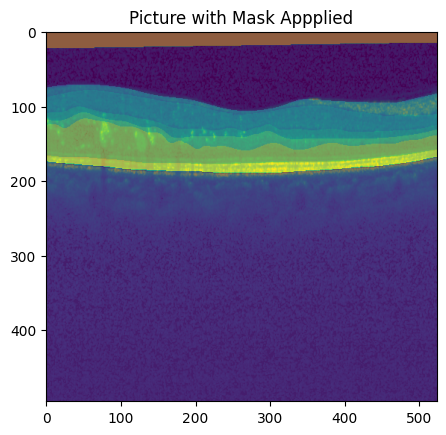

In [64]:
img = Image.open(f"{df_img['file_path'][15]}")
mask = Image.open(f"{df_msk['file_path'][15]}")

print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)

plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

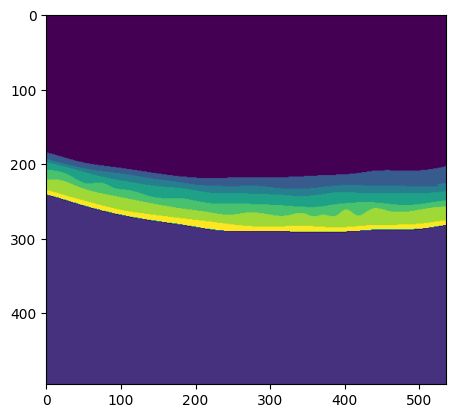

In [65]:
mask = Image.open(f"{df_msk['file_path'][10]}")
plt.imshow(mask)
plt.show()

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   key        880 non-null    object
 1   class      880 non-null    object
 2   pacient    880 non-null    object
 3   width      880 non-null    int64 
 4   length     880 non-null    int64 
 5   file_path  880 non-null    object
dtypes: int64(2), object(4)
memory usage: 41.4+ KB


In [70]:
# salvar dataframe com todas imagens e máscaras coletadas

caminho = "/data/oct_segmentation/planilha_dados"

if not os.path.exists(caminho):
    os.makedirs(caminho)

df.to_csv(f'{caminho}/dataset_csv.csv', index=False)